## Arm Reaching (RM Session 1)

In [1]:
import os
import glob
import numpy as np
import mne
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')
from scipy.io import loadmat
from scipy.signal import butter, lfilter

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne.decoding import CSP
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### BrainVision (.vhdr, .vmrk, .eeg)

The BrainVision file format consists of three separate files:

1. A text header file (.vhdr) containing meta data.

2. A text marker file (.vmrk) containing information about events in the data.

3. A binary data file (.eeg) containing the voltage values of the EEG.

In [6]:
folder_path=r'D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI'
folder_files=os.listdir(folder_path)
for i in folder_files:
    print(i)

session1_sub10_reaching_MI.eeg
session1_sub10_reaching_MI.vhdr
session1_sub10_reaching_MI.vmrk
session1_sub11_reaching_MI.eeg
session1_sub11_reaching_MI.vhdr
session1_sub11_reaching_MI.vmrk
session1_sub12_reaching_MI.eeg
session1_sub12_reaching_MI.vhdr
session1_sub12_reaching_MI.vmrk
session1_sub13_reaching_MI.eeg
session1_sub13_reaching_MI.vhdr
session1_sub13_reaching_MI.vmrk
session1_sub14_reaching_MI.eeg
session1_sub14_reaching_MI.vhdr
session1_sub14_reaching_MI.vmrk
session1_sub15_reaching_MI.eeg
session1_sub15_reaching_MI.vhdr
session1_sub15_reaching_MI.vmrk
session1_sub16_reaching_MI.eeg
session1_sub16_reaching_MI.vhdr
session1_sub16_reaching_MI.vmrk
session1_sub17_reaching_MI.eeg
session1_sub17_reaching_MI.vhdr
session1_sub17_reaching_MI.vmrk
session1_sub18_reaching_MI.eeg
session1_sub18_reaching_MI.vhdr
session1_sub18_reaching_MI.vmrk
session1_sub19_reaching_MI.eeg
session1_sub19_reaching_MI.vhdr
session1_sub19_reaching_MI.vmrk
session1_sub1_reaching_MI.eeg
session1_sub1_reachi

In [4]:
eeg,vhdr,vmrk = [],[],[]

for i in folder_files:
    file=folder_path+'\\'+i
    if '.eeg' in file:
        eeg.append(file) 
    elif '.vhdr' in file:
        vhdr.append(file) 
    else:
        vmrk.append(file)
        
for i in range(0,len(eeg)):
    print(eeg[i]+'\n'+vhdr[i]+'\n'+vmrk[i]+'\n')

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub10_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub10_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub10_reaching_MI.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub11_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub11_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub11_reaching_MI.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub12_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub12_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub12_reaching_MI.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub13_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub13_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub13_reaching_MI.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub14_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData

### Read Raw Signals

In [7]:
raw = mne.io.read_raw_brainvision(vhdr[11], misc='auto', scale=1.0, preload=True, verbose=None)
raw # OR raw.info

Extracting parameters from D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub20_reaching_MI.vhdr...
Setting channel info structure...
Reading 0 ... 8597599  =      0.000 ...  3439.040 secs...


<RawBrainVision | session1_sub20_reaching_MI.eeg, 71 x 8597600 (3439.0 s), ~4.55 GB, data loaded>

In [8]:
raw.set_channel_types(mapping={'hEOG_L': 'eog', 'hEOG_R': 'eog', 'vEOG_U': 'eog', 'vEOG_D': 'eog'})
raw.set_channel_types(mapping={'EMG_1': 'emg', 'EMG_2': 'emg', 'EMG_3': 'emg', 'EMG_4': 'emg', 'EMG_5': 'emg', 'EMG_6': 'emg', 'EMG_ref': 'emg'})
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, AFz, F7, F5, F3, F1, Fz, FT7, FC5, FC3, FC1, T7, ...
 chs: 60 EEG, 4 EOG, 7 EMG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1250.0 Hz
 meas_date: 2019-07-31 11:39:11 UTC
 nchan: 71
 projs: []
 sfreq: 2500.0 Hz
>

In [9]:
print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
print(raw.info['sfreq'], 'Hz')            # sampling frequency
print(raw.info['description'], '\n')      # miscellaneous acquisition info

bad channels: []
2500.0 Hz
None 



Using matplotlib as 2D backend.


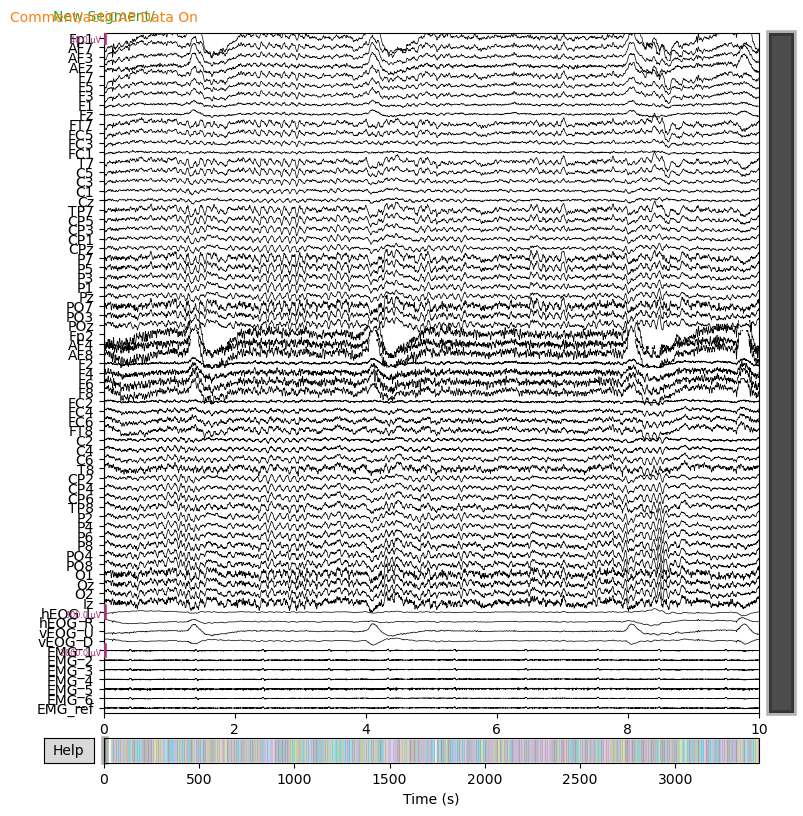

In [10]:
raw.plot(n_channels=71);

### For One Session, Each Subject Do :
 - 50 Trials For Each Class : 50 x 6 ( Classes ) = Total 300 Trials
 
 - Each Trial has Time Duration 7s ( 3s Visual Cue + 4s Movement Implementation )

 - and There Are 300 Rest Periods Between Those Trials ( Each Rest Period has Time Duration 4s )
 
 - Finally,
      Total Session Time = 50 x 6 x 7 + 300 x 4 = almost 3300 seconds 

In [8]:
print('First Time : ',raw.first_time)
print('Last Time  : ',raw._last_time)

First Time :  0.0
Last Time  :  4022.1196


- Therefore, The Total Count of Samples For All Trials : 300 ( Trials ) x 7s x 2500 (Fs) + 300 (Rests) x 4s x 2500 (Fs) is almost 8,250,000

In [9]:
print('Total Samples : ',len(raw))
print('Start : ',raw._first_samps) 
print('End : ',raw._last_samps)

Total Samples :  10055300
Start :  [0]
End :  [10055299]


### time_as_index()
- Convert time to indices ( time ( s ) : index ( 0-based ) )

- Input : List of numbers or a number representing points in time.

- Return : Indices relative to first_samp corresponding to the times supplied.

In [10]:
print(raw.time_as_index([1, 2, 3, 4, 5]), '\n')
print(np.diff(raw.time_as_index([1, 2, 3])))

[ 2500  5000  7500 10000 12500] 

[2500 2500]


### Electrodes Handling :
### pick_types() : Picking Some Type of Signals and Ignore Others.
### pick_channels() : pick channels by name.
### drop_channels() : method to remove channels by name.

In [11]:
# # this piece of code does not make changes in this case, only for learn

# eeg_and_eog = raw.copy().pick_types(emg=False, eeg=True, eog=True)
# print(len(raw.ch_names), '→', len(eeg_and_eog.ch_names))

### We Will Select Channels According to International Standard 10–20 system 

<img src="The-location-map-of-32-channels-cap-The-electrodes-can-be-divided-into-3-groups.png" style="width:400px;hight:400;"/>

In [11]:
print(raw.ch_names)

['Fp1', 'AF7', 'AF3', 'AFz', 'F7', 'F5', 'F3', 'F1', 'Fz', 'FT7', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'Cz', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'P7', 'P5', 'P3', 'P1', 'Pz', 'PO7', 'PO3', 'POz', 'hEOG_L', 'hEOG_R', 'vEOG_U', 'vEOG_D', 'Fp2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'FC2', 'FC4', 'FC6', 'FT8', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz', 'EMG_1', 'EMG_2', 'EMG_3', 'EMG_4', 'EMG_5', 'EMG_6', 'EMG_ref']


In [8]:
selected_channels = ["Fp1", "AF3","F7","F3","FC1","FC5","T7","C3","CP1","CP5","P7","P3", "PO3", "O1",  # Brain Left Side
                     "Fz","Cz","Pz","Oz",                                                              # Brain Mid
                     "O2","FC2","F4","F8","AF4","Fp2","C4", "T8","FC6","CP2","PO4","P4","P8","CP6",    # Brain Right Side   
                     "hEOG_L", "hEOG_R", "vEOG_U", "vEOG_D"]                                           # EOG Channels                                

In [9]:
raw.pick_channels(ch_names=selected_channels)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
print(len(raw.ch_names))

36


Using matplotlib as 2D backend.


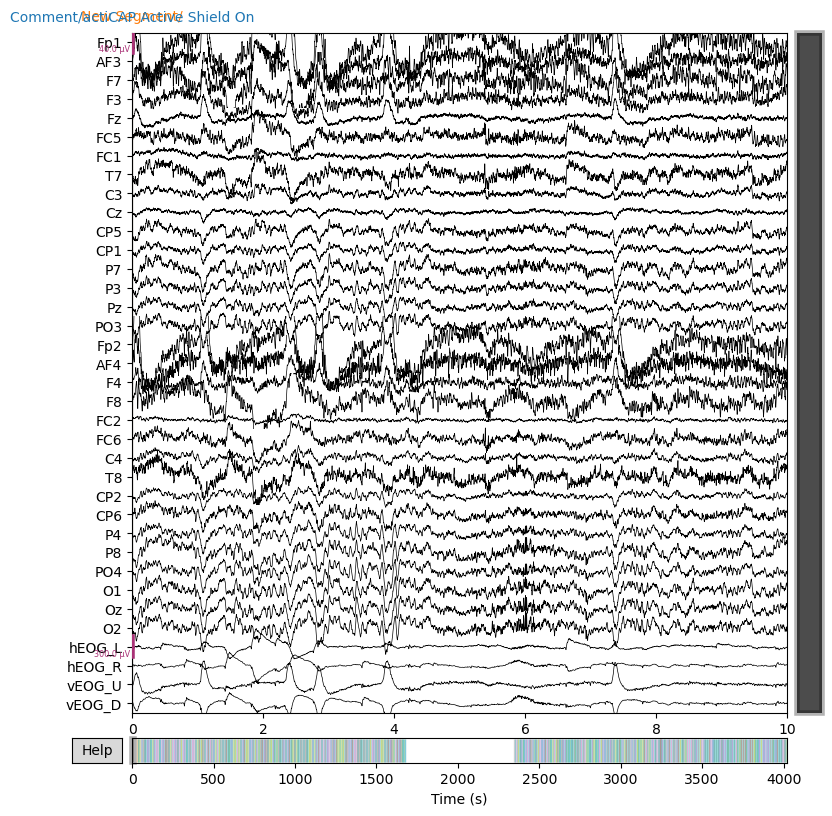

In [10]:
raw.plot(n_channels=36);

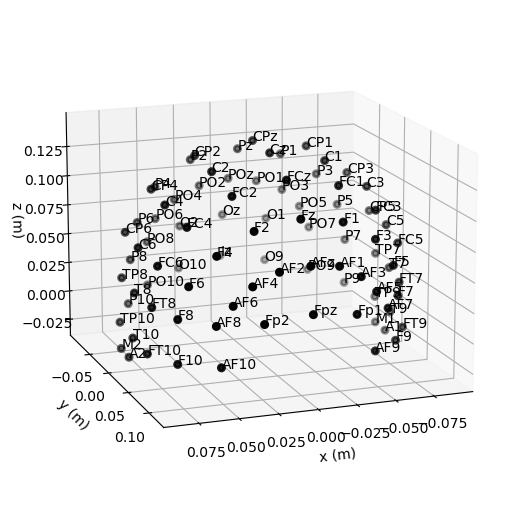

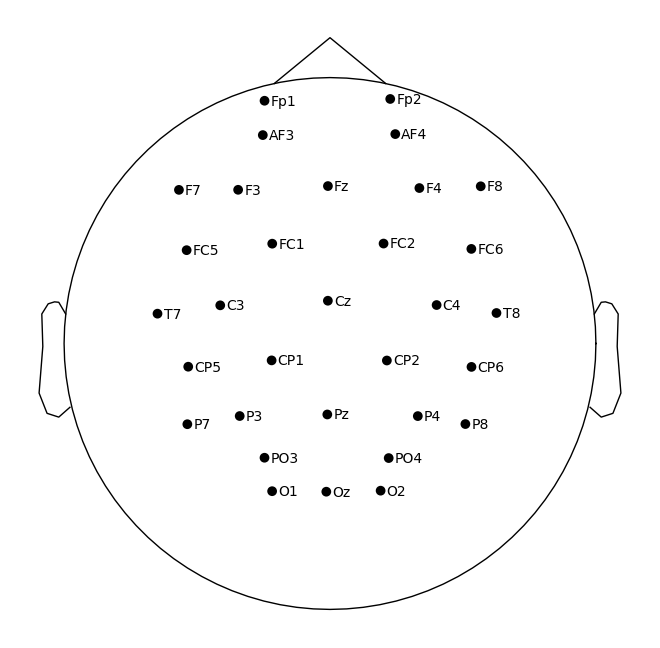

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


In [14]:
raw.plot_sensors(show_names=True,sphere=0.11);
fig = montage.plot(kind='3d',show=False)
fig = fig.gca().view_init(azim=70, elev=15)  # set view angle for tutorial

### Plotting spectral density of continuous data

- To visualize the frequency content of continuous data

- the Raw object provides a compute_psd() method to compute spectral density and the resulting Spectrum object has a plot() method

Effective window size : 0.102 (s)


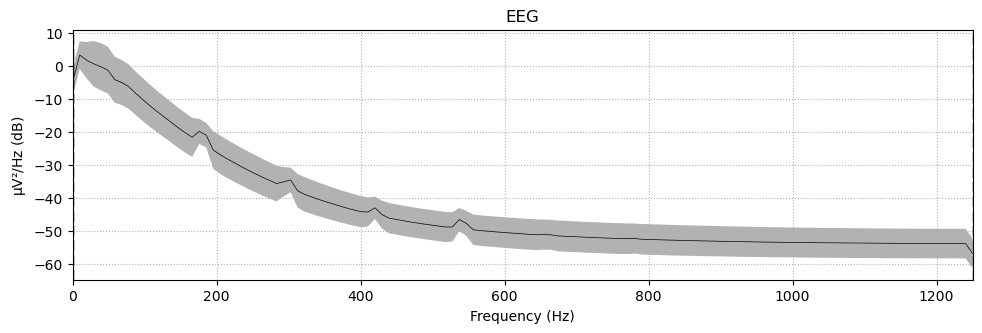

In [12]:
spectrum = raw.compute_psd()
spectrum.plot(average=True)

### plot spectral power estimates across sensors as a scalp topography
- will compute power based on magnetometer channels (if present), and will plot the power estimates on a dB-like log-scale.

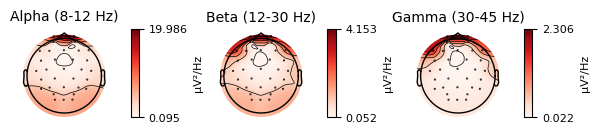

In [17]:
spectrum.plot_topomap(bands={'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),'Gamma (30-45 Hz)': (30,45)});

### plot the PSD for every sensor on its own axes
- the axes arranged spatially to correspond to sensor locations in space.

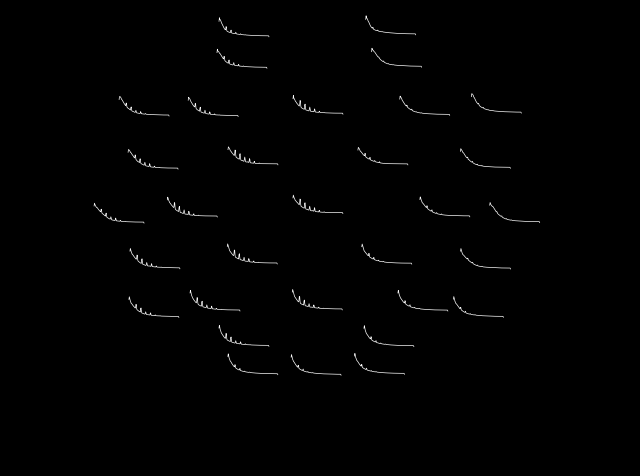

In [18]:
spectrum.plot_topo();

### Bandpass Filtering the Data
- Filtering to remove slow drift.
- Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit.

In [8]:
raw.filter(l_freq=8,h_freq=30, method='iir', iir_params=dict(order=4, ftype='butter', output='sos'), phase='zero-double')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



<RawBrainVision | session1_sub1_reaching_MI.eeg, 71 x 10055300 (4022.1 s), ~5.32 GB, data loaded>

Using matplotlib as 2D backend.


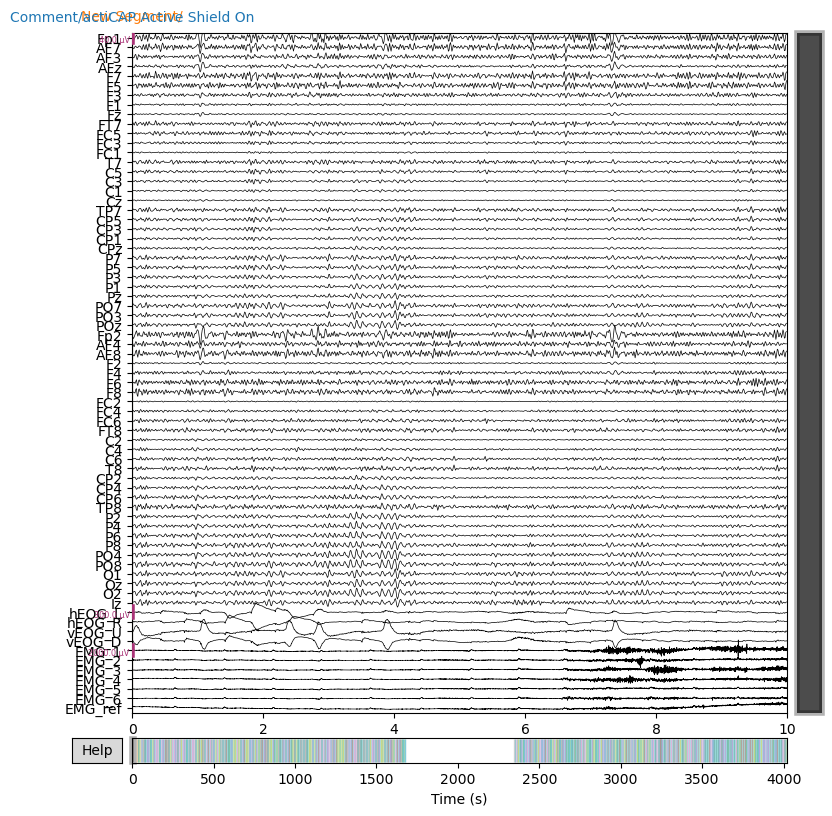

In [9]:
raw.plot(n_channels=71);

Effective window size : 0.102 (s)


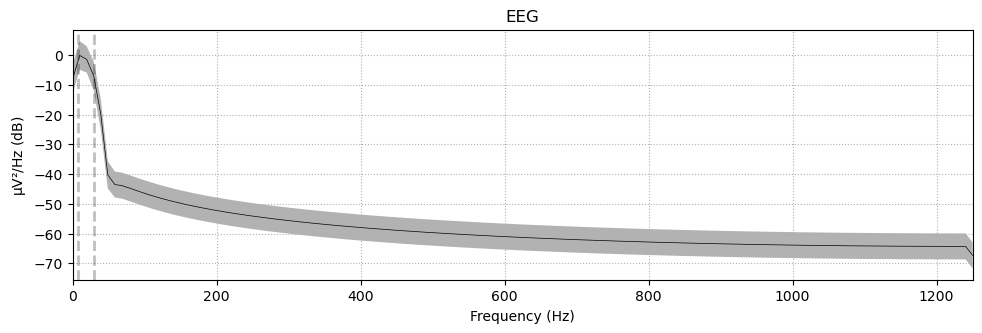

In [21]:
spectrum = raw.compute_psd()
spectrum.plot(average=True)

### Refrencing EEG

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


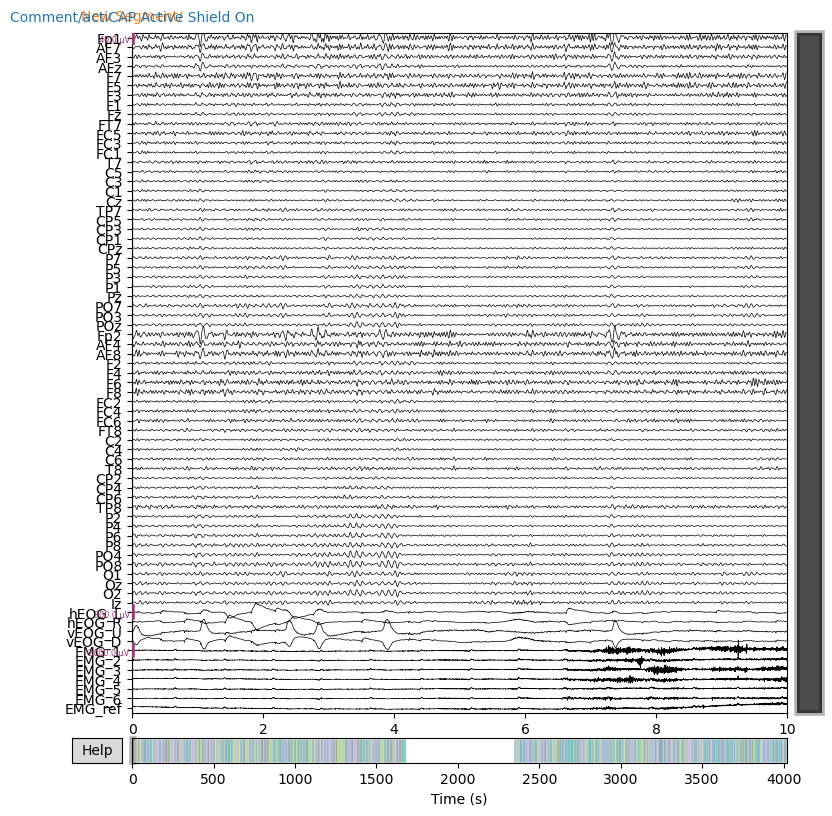

In [11]:
# Average reference. This is normally added by default, but can also be added
# explicitly.
raw.set_eeg_reference(ref_channels='average')
raw.plot(n_channels=71);

In [24]:
# ### Detect Ocular artifacts (EOG)

# - MNE-Python includes functions for detecting and extracting ocular artifacts: find_eog_events() and create_eog_epochs(). Once again we’ll use the higher-level convenience function that automatically finds the artifacts and extracts them in to an Epochs object in one step. 

# - ocular artifacts are usually most prominent in the EEG channels.

# - note that there are many fewer blinks than heartbeats, which makes the image plots appear somewhat blocky.

In [25]:
# # baseline : The electrical signal from a sensor when no measured variable is present. Often referred to the output at no-load condition
# eog_epochs = mne.preprocessing.create_eog_epochs(raw,ch_name=["hEOG_L", "hEOG_R", "vEOG_U", "vEOG_D"], baseline=(-0.5, -0.2))
# eog_epochs.plot_image(combine='mean');
# eog_epochs.average().plot_joint();

In [26]:
# eog_epochs

In [27]:
# ### Repairing artifacts with regression --Raw Data--
# Remove EOG artifact signals from other channels by regression.

In [28]:
# weights = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(raw)

In [29]:
# fig = weights.plot(vlim=(None, 0.4))  # regression coefficients / weights as topomap
# fig.set_size_inches(3, 2)

In [30]:
# # Fit the regression model
# raw_clean = weights.apply(raw, copy=False)

# # Show the filter weights in a topomap
# weights.plot();

In [31]:
# ### Repairing artifacts with ICA
# Note : ICA fitting is not deterministic (e.g., the components may get a sign flip on different runs, or may not always be returned in the same order), so we’ll also specify a random seed so that we get identical results each time this tutorial is built by our web servers

In [32]:
# ica = mne.preprocessing.ICA(n_components=32, max_iter='auto',random_state=0,method='infomax')
# ica.fit(raw.copy()) 

In [33]:
# ica.plot_components();

In [34]:
# # use automatic detection
# bad_indx,scores = ica.find_bads_eog(raw,ch_name=["hEOG_L","hEOG_R","vEOG_U","vEOG_D"],threshold=3,)
# print(bad_indx)

In [35]:
# raw.plot(n_channels=32);

In [36]:
# ica.exclude = bad_indx
# ica.apply(raw.copy(),exclude=ica.exclude).plot();

In [37]:
# ica.apply(raw,exclude=ica.exclude)

### Read Events & Epoching

In [13]:
events = mne.events_from_annotations(raw)

Used Annotations descriptions: ['Comment/actiCAP Active Shield On', 'Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']


In [14]:
events

(array([[      0,       0,   99999],
        [      0,       0,   10002],
        [  96910,       0,      13],
        ...,
        [8570550,       0,      51],
        [8580585,       0,       8],
        [8585592,       0,      14]]),
 {'Comment/actiCAP Active Shield On': 10001,
  'Comment/actiCAP Data On': 10002,
  'New Segment/': 99999,
  'Stimulus/S  1': 1,
  'Stimulus/S  2': 2,
  'Stimulus/S  3': 3,
  'Stimulus/S  4': 4,
  'Stimulus/S  5': 5,
  'Stimulus/S  6': 6,
  'Stimulus/S  8': 8,
  'Stimulus/S 11': 11,
  'Stimulus/S 13': 13,
  'Stimulus/S 14': 14,
  'Stimulus/S 21': 21,
  'Stimulus/S 31': 31,
  'Stimulus/S 41': 41,
  'Stimulus/S 51': 51,
  'Stimulus/S 61': 61})

In [15]:
# selected_events = mne.pick_events(events[0], exclude=[99999,10001,10002,10003,1,2,3,4,5,6,13,14])
selected_events = mne.pick_events(events[0])
list(selected_events)

[array([    0,     0, 99999]),
 array([    0,     0, 10002]),
 array([96910,     0,    13]),
 array([106985,      0,      4]),
 array([114499,      0,     41]),
 array([124546,      0,      8]),
 array([134628,      0,      4]),
 array([142140,      0,     41]),
 array([152179,      0,      8]),
 array([162254,      0,      1]),
 array([169763,      0,     11]),
 array([179802,      0,      8]),
 array([189884,      0,      6]),
 array([197394,      0,     61]),
 array([207432,      0,      8]),
 array([217514,      0,      1]),
 array([225023,      0,     11]),
 array([235061,      0,      8]),
 array([245141,      0,      3]),
 array([252650,      0,     31]),
 array([262689,      0,      8]),
 array([272763,      0,      5]),
 array([280273,      0,     51]),
 array([290313,      0,      8]),
 array([300388,      0,      1]),
 array([307898,      0,     11]),
 array([317937,      0,      8]),
 array([328011,      0,      6]),
 array([335521,      0,     61]),
 array([345560,      0,

In [16]:
event_ids = {'Stimulus/S 11': 11,'Stimulus/S 21': 21,'Stimulus/S 31': 31,'Stimulus/S 41': 41,'Stimulus/S 51': 51,'Stimulus/S 61': 61}
epochs = mne.Epochs(raw, events=selected_events, event_id=event_ids, tmin=0, tmax=4, preload=True,baseline=(0, 0))
epochs

Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 10001 original time points ...
0 bad epochs dropped


Number of events,300
Events,Stimulus/S 11: 50Stimulus/S 21: 50Stimulus/S 31: 50Stimulus/S 41: 50Stimulus/S 51: 50Stimulus/S 61: 50
Time range,0.000 – 4.000 sec
Baseline,0.000 – 0.000 sec


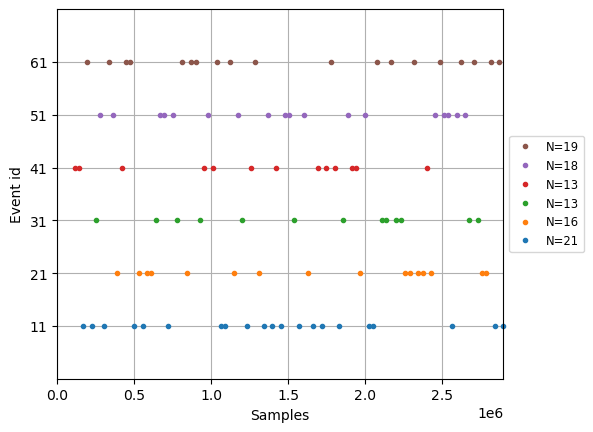

In [18]:
mne.viz.plot_events(epochs.events[:100]);

In [19]:
epochs.get_data().shape

(300, 71, 10001)

### Epochs Downsampling

In [75]:
# epochs.resample(sfreq=625)
# epochs.get_data().shape

In [76]:
# epochs.plot(n_epochs=5);

### Repairing artifacts with ICA 
Note : ICA fitting is not deterministic (e.g., the components may get a sign flip on different runs, or may not always be returned in the same order), so we’ll also specify a random seed so that we get identical results each time this tutorial is built by our web servers

In [ ]:
# ica = mne.preprocessing.ICA(n_components=20, max_iter='auto',random_state=0,method='infomax')
# ica.fit(epochs.copy()) 

In [ ]:
# ica.plot_components();

In [ ]:
# # use automatic detection
# bad_indx,scores = ica.find_bads_eog(raw,ch_name=["hEOG_L","hEOG_R","vEOG_U","vEOG_D"],threshold=2)
# print(bad_indx)

In [ ]:
# epochs.plot(n_epochs=5);

In [ ]:
# ica.exclude = bad_indx
# ica.apply(epochs.copy(),exclude=ica.exclude).plot(n_epochs=5);

In [ ]:
# ica.apply(epochs,exclude=ica.exclude)

### Repairing artifacts with regression 
Remove EOG artifact signals from other channels by regression.

In [ ]:
# # plotting before
# # plot the evoked for the EEG and the EOG sensors
# fig = epochs.average('all').plot()
# fig.set_size_inches(6, 6)

In [ ]:
# # Perform regression using the EOG sensor as independent variable and the EEG
# # sensors as dependent variables.
# model_plain = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(epochs)
# fig = model_plain.plot(vlim=(None, 0.4))  # regression coefficients as topomap
# fig.set_size_inches(3, 2);

In [ ]:
# epochs_clean_plain = model_plain.apply(epochs)
# # After regression, we should redo the baseline correction
# epochs_clean_plain.apply_baseline(baseline=(3, 7))
# # Show the evoked potential computed on the corrected data
# fig = epochs_clean_plain.average('all').plot()
# fig.set_size_inches(6, 6)

In [ ]:
# # create epochs with the evoked subtracted out
# epochs_sub = epochs.copy().subtract_evoked()

# # perform regression
# model_sub = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(epochs_sub)
# fig = model_sub.plot(vlim=(None, 0.4))
# fig.set_size_inches(3, 2)

# # apply the regression coefficients to the original epochs
# epochs_clean_sub = model_plain.apply(epochs).apply_baseline(baseline=(3, 7))
# fig = epochs_clean_sub.average('all').plot()
# fig.set_size_inches(6, 6)

In [ ]:
# eog_epochs = mne.preprocessing.create_eog_epochs(raw)
# # We need to explicitly specify that we want to average the EOG channel too.
# eog_evoked = eog_epochs.average('all')
# eog_evoked.plot('all')
# fig.set_size_inches(6, 6)

# # perform regression on the evoked blink response
# model_evoked = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(eog_evoked)
# fig = model_evoked.plot(vlim=(None, 0.4))
# fig.set_size_inches(3, 2)

# # apply the regression coefficients to the original epochs
# epochs_clean_evoked = model_evoked.apply(epochs).apply_baseline(baseline=(3, 7))
# fig = epochs_clean_evoked.average('all').plot()
# fig.set_size_inches(6, 6)

# # for good measure, also show the effect on the blink evoked
# eog_evoked_clean = model_evoked.apply(eog_evoked)
# eog_evoked_clean.apply_baseline(baseline=(0, 0))
# eog_evoked_clean.plot('all')
# fig.set_size_inches(6, 6)

In [ ]:
# order = np.concatenate([  # plotting order: EOG first, then EEG
#     mne.pick_types(raw.info, meg=False, eog=True),
#     mne.pick_types(raw.info, meg=False, eeg=True),
# ])
# raw_kwargs = dict(events=eog_epochs.events, order=order, start=13, duration=3,
#                   n_channels=10, scalings=dict(eeg=50e-6, eog=250e-6))

# # plot original data
# raw.plot(**raw_kwargs);

# # regress (using coefficients computed previously) and plot
# raw_clean = model_evoked.apply(raw)
# raw_clean.plot(**raw_kwargs);

In [ ]:
# epochs.apply_baseline((None,0))

In [ ]:
# epochs["Stimulus/S 41"].plot_image(picks=[5]); # picks=[channel index]

In [ ]:
# epochs.equalize_event_counts(event_ids)
# epochs

## Prepare & Split data

In [20]:
epochs.pick_types(eeg=True)
data = epochs.get_data()

In [21]:
labels = np.empty(shape=(data.shape[0]))
decode = {11: 0, 21: 1, 31: 2, 41:3, 51: 4, 61: 5, 8 :6}
k=0
for i in epochs.events:
    labels[k]=decode[i[2]]
    k+=1

In [22]:
data.shape

(300, 60, 10001)

In [23]:
labels.shape

(300,)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2,stratify=labels,shuffle=True)

In [ ]:
# y_train=tf.keras.utils.to_categorical(y_train,num_classes=6) 
# y_val=tf.keras.utils.to_categorical(y_val,num_classes=6) 

In [25]:
# Normaliation
# X_train = MinMaxScaler().fit_transform(X_train)
# X_val = MinMaxScaler().fit_transform(X_val)
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_val = (X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val))

In [42]:
# def preprocess_input(eeg_signals):
#     eeg_signals_3d = np.zeros((eeg_signals.shape[0], 32, 2500, 3))
#     for i in range(eeg_signals.shape[0]):
#         trial_3d = np.dstack([eeg_signals[0],eeg_signals[0],eeg_signals[0]])
#         eeg_signals_3d[i] = trial_3d
#     return eeg_signals_3d
# X_train = preprocess_input(X_train)
# X_val = preprocess_input(X_val)

In [26]:
print('X_train: ',X_train.shape)
print('X_val:   ',X_val.shape)
print('y_train: ',y_train.shape)
print('y_val:   ',y_val.shape)

X_train:  (240, 60, 10001)
X_val:    (60, 60, 10001)
y_train:  (240,)
y_val:    (60,)


## ML Models

In [30]:
CSP?

Init signature:
CSP(
    n_components=4,
    reg=None,
    log=None,
    cov_est='concat',
    transform_into='average_power',
    norm_trace=False,
    cov_method_params=None,
    rank=None,
    component_order='mutual_info',
)
Docstring:     
M/EEG signal decomposition using the Common Spatial Patterns (CSP).

This class can be used as a supervised decomposition to estimate spatial
filters for feature extraction. CSP in the context of EEG was first
described in :footcite:`KolesEtAl1990`; a comprehensive tutorial on CSP can
be found in :footcite:`BlankertzEtAl2008`. Multi-class solving is
implemented from :footcite:`Grosse-WentrupBuss2008`.

Parameters
----------
n_components : int (default 4)
    The number of components to decompose M/EEG signals. This number should
    be set by cross-validation.
reg : float | str | None (default None)
    If not None (same as ``'empirical'``, default), allow regularization
    for covariance estimation. If float (between 0 and 1), shrinkage is
   

In [40]:
csp = CSP(n_components=30, reg=None, log=True, norm_trace=True)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(X_train, y_train)

# Apply CSP transform to training data
X_train_csp = csp.transform(X_train)
X_val_csp = csp.transform(X_val)

Computing rank from data with rank=None
    Using tolerance 31 (2.2e-16 eps * 60 dim * 2.3e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 31 (2.2e-16 eps * 60 dim * 2.3e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 60 dim * 2.3e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 31 (2.2e-16 eps * 60 dim * 2.3e+15  max singular value)
    Estimated rank (

In [41]:
print('X_train: ',X_train_csp.shape)
print('X_val:   ',X_val_csp.shape)

X_train:  (240, 30)
X_val:    (60, 30)


In [35]:
LinearDiscriminantAnalysis?

Init signature:
LinearDiscriminantAnalysis(
    solver='svd',
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None,
)
Docstring:     
Linear Discriminant Analysis.

A classifier with a linear decision boundary, generated by fitting class
conditional densities to the data and using Bayes' rule.

The model fits a Gaussian density to each class, assuming that all classes
share the same covariance matrix.

The fitted model can also be used to reduce the dimensionality of the input
by projecting it to the most discriminative directions, using the
`transform` method.

.. versionadded:: 0.17
   *LinearDiscriminantAnalysis*.

Read more in the :ref:`User Guide <lda_qda>`.

Parameters
----------
solver : {'svd', 'lsqr', 'eigen'}, default='svd'
    Solver to use, possible values:
      - 'svd': Singular value decomposition (default).
        Does not compute the covariance matrix, therefore this solver is
        rec

In [42]:
lda = LinearDiscriminantAnalysis(solver='svd')  # ‘svd’, ‘lsqr’, ‘eigen’
lda.fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_val_csp, y_val]

# model accuracy for svc model

train_accuracy = lda.score(*evaluate_train)
test_accuracy = lda.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  0.8625
test accuracy:   0.2


In [43]:
# training a linear SVM classifier
from sklearn import svm

# linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
model = svm.SVC(kernel='poly', degree=10, C=2).fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_val_csp, y_val]

# model accuracy for svc model

train_accuracy = model.score(*evaluate_train)
test_accuracy = model.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  1.0
test accuracy:   0.25


In [44]:
# training a linear SVM classifier

svm_kernel_ovo = OneVsOneClassifier(SVC(kernel='poly', degree=6, C=2)).fit(X_train_csp, y_train)
svm_kernel_ovr = OneVsRestClassifier(SVC(kernel='poly', degree=6, C=2)).fit(X_train_csp, y_train)

svm_linear_ovo = OneVsOneClassifier(LinearSVC(C=10),).fit(X_train_csp, y_train)
svm_linear_ovr = OneVsRestClassifier(LinearSVC(C=10)).fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_val_csp, y_val]

# model accuracy for svc model
train_accuracy = svm_kernel_ovr.score(*evaluate_train)
test_accuracy = svm_kernel_ovr.score(*evaluate_test)
print('Linear Kernel OneVsRest SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

train_accuracy = svm_kernel_ovo.score(*evaluate_train)
test_accuracy = svm_kernel_ovo.score(*evaluate_test)
print('Linear Kernel OneVsOne SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

train_accuracy = svm_linear_ovr.score(*evaluate_train)
test_accuracy = svm_linear_ovr.score(*evaluate_test)
print('LinearSVC OneVsRest SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

train_accuracy = svm_linear_ovo.score(*evaluate_train)
test_accuracy = svm_linear_ovo.score(*evaluate_test)
print('LinearSVC OneVsOne SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

Linear Kernel OneVsRest SVM accuracy: 
          train accuracy:  1.0
          test accuracy:   0.21666666666666667
________________________________________
Linear Kernel OneVsOne SVM accuracy: 
          train accuracy:  1.0
          test accuracy:   0.2
________________________________________
LinearSVC OneVsRest SVM accuracy: 
          train accuracy:  0.7833333333333333
          test accuracy:   0.2
________________________________________
LinearSVC OneVsOne SVM accuracy: 
          train accuracy:  1.0
          test accuracy:   0.16666666666666666
________________________________________
